## Problem Statement:Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices.


### Reading Data From Yahoo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
df=pdr.DataReader("^BSESN" , data_source='yahoo', start='1997-10-10',end='2020-10-10')

In [ ]:
df.to_csv('^BSESN.csv')

In [ ]:
df=pd.read_csv('^BSESN.csv')

In [ ]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1997-10-10,4083.989990,3999.649902,3999.649902,4057.370117,0.0,4057.370117
1,1997-10-13,4118.919922,4056.479980,4093.919922,4066.050049,0.0,4066.050049
2,1997-10-14,4062.810059,4011.110107,4061.510010,4012.399902,0.0,4012.399902
3,1997-10-15,4042.689941,3999.139893,4015.550049,4034.550049,0.0,4034.550049
4,1997-10-16,4090.510010,4046.469971,4082.659912,4077.050049,0.0,4077.050049


In [ ]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
5655,2020-10-05,39263.851562,38819.890625,38956.781250,38973.699219,15500.0,38973.699219
5656,2020-10-06,39623.761719,39191.101562,39336.339844,39574.570312,11300.0,39574.570312
5657,2020-10-07,39968.039062,39450.820312,39633.191406,39878.949219,15000.0,39878.949219
5658,2020-10-08,40468.878906,40062.230469,40204.320312,40182.671875,14400.0,40182.671875
5659,2020-10-09,40585.359375,40066.539062,40226.250000,40509.488281,16600.0,40509.488281


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5660 non-null   object 
 1   High       5660 non-null   float64
 2   Low        5660 non-null   float64
 3   Open       5660 non-null   float64
 4   Close      5660 non-null   float64
 5   Volume     5660 non-null   float64
 6   Adj Close  5660 non-null   float64
dtypes: float64(6), object(1)
memory usage: 309.7+ KB


In [ ]:
df1=df['Close']

In [ ]:
df1.shape

(5660,)

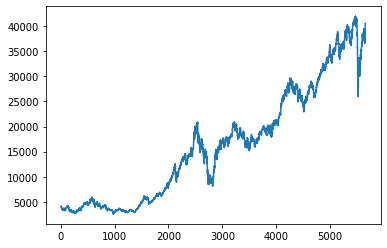

In [ ]:
plt.plot(df1)

### LSTM is sensitive to the scale of data so we take MinMax Scala

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

### Preprocess the Data

Splitting the Dataset in Train and test-For training and testing of Data we have different methods like Randomseed, Cross Validation but here we are dividing the data into train and test in a different manner as it is a timeSeries Data.
Example:20,50,30,80 |||| 50,20,30

Train-20,50,30,80,90

Test=50,20,30,10,30

In [ ]:
training_size=int(len(df1)*0.65) ## 65 % of the total length of the dataframe
test_size=len(df1)-training_size ## Lenth of dataframe minus train size 35%
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
train_data.shape,test_data.shape

((3679, 1), (1981, 1))

Say Timesteps=3

X_train                        Y_train(o/p)                          X_test          Y_test(o/p)

20,50,30                          80                                 50,20,30          10

5030,80                           90                                 20,30,10          30                        


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(3578, 100)
(3578,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(1880, 100)
(1880,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
56/56 [==============================] - 18s 238ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 2/100
56/56 [==============================] - 11s 196ms/step - loss: 2.1982e-04 - val_loss: 0.0020
Epoch 3/100
56/56 [==============================] - 11s 193ms/step - loss: 1.7748e-04 - val_loss: 0.0022
Epoch 4/100
56/56 [==============================] - 11s 195ms/step - loss: 1.7830e-04 - val_loss: 0.0029
Epoch 5/100
56/56 [==============================] - 11s 193ms/step - loss: 1.8048e-04 - val_loss: 0.0022
Epoch 6/100
56/56 [==============================] - 11s 192ms/step - loss: 1.6227e-04 - val_loss: 0.0027
Epoch 7/100
56/56 [==============================] - 11s 200ms/step - loss: 1.5413e-04 - val_loss: 0.0025
Epoch 8/100
56/56 [==============================] - 13s 230ms/step - loss: 1.5769e-04 - val_loss: 0.0021
Epoch 9/100
56/56 [==============================] - 12s 208ms/step - loss: 1.5111e-04 - val_loss: 0.0059
Epoch 10/100
56/56 [==============================

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:

### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

11198.165481905491

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

29715.602138275855

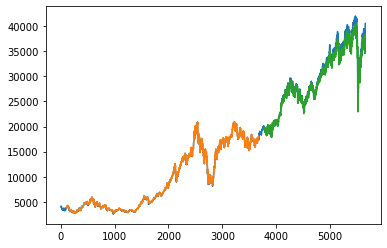

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

1981

In [ ]:
x_input=test_data[1881:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.91714793]
101
1 day input [0.71335909 0.71175083 0.73705849 0.75218761 0.7578673  0.78021454
 0.79347955 0.80069657 0.79742258 0.80521215 0.80732993 0.79681251
 0.80419093 0.78618243 0.79234518 0.77831583 0.78788112 0.78540867
 0.80319989 0.81650729 0.82107091 0.83426217 0.819995   0.81931197
 0.82767657 0.82234654 0.82118476 0.83385609 0.84476391 0.84928008
 0.86111819 0.86587617 0.85709635 0.86748145 0.86383839 0.86636335
 0.84957578 0.85005225 0.86072173 0.87465886 0.88479411 0.89778795
 0.89629354 0.9031279  0.90283388 0.89789981 0.9120849  0.90136588
 0.89285159 0.88956896 0.87261226 0.89162778 0.89100312 0.9002051
 0.90058935 0.90418525 0.90990111 0.90895117 0.90744832 0.89644144
 0.90084882 0.91298373 0.91518102 0.90515882 0.91060519 0.91986405
 0.9210025  0.9268482  0.92785313 0.93684468 0.91552407 0.92244896
 0.92715591 0.92473955 0.90863482 0.91016079 0.90884247 0.90448622
 0.92091207 0.92127368 0.91878536 0.92609677 0.93266561 0.92445774
 0.92105183 0.90042596 0.89280097 

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df1)

5660

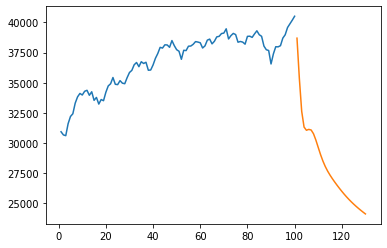

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[5560:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

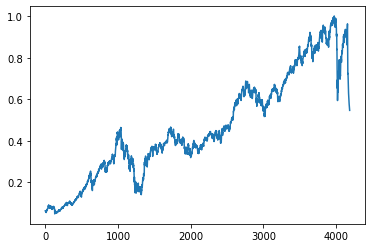

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1500:])